# User Guide

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/imartinezl/difw/HEAD)

## Introduction

The DIFW library allows to create transformations $\phi(x,t)$ based on the integration of a continuous piecewise affine velocity field $v(x)$. Let us bring some clarity to this sentence by including some definitions:

- The transformation $\phi(x,t)$ is created by the integration of a velocity field. For that, we need to solve a differential equation of the form: 

$$\frac{\partial\phi(x,t)}{\partial t} = v(\phi(x))$$

The transformation $\phi(x,t)$ depend on two variables $x$ (spatial dimension) and $t$ (integration time).

- The velocity field $v(x)$ can be a function of any form and shape, but in this library we focus on an specific type of functions, which are continuous piecewise affine functions.

- Continous function: there are no discontinuities in the function domain
- Piecewise function: is a function that is defined by parts
- Affine: is a geometric transformation that consist on a linear transformation + a translation.

Thus, a continous, piecewise, and affine function is just a set of lines joined together. 
In summary, in this library integrate (efficiently) these functions to create diffeomorphic transformations $\phi(x,t)$ that are very useful for a lot of tasks in machine learning.

## Loading libraries

First, we need to import the necessary Python libraries: ``difw`` library to compute the transformations, ``matplotlib`` for data visualization, ``numpy`` for array manipulation and ``pytorch`` for autodifferentiation and gradient descent optimization.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import difw

plt.rcParams["figure.figsize"] = (10, 7)

## Transformation parameters

In order to create a transformation $\phi(x,t)$, several options need to be specified. CPAB transformations are built by integrating a continuous piecewise affine velocity field $v(x)$. Such velocity field is defined onto a regular grid, or tesselation. In this example, we will set the number of intervals to 5 (``tess_size=5``).

The ``backend`` option let us choose between ``numpy`` backend and the ``pytorch`` backend, the preferred option for optimization tasks. These computations can be also executed on CPU or GPU ``device`` (for the ``pytorch`` backend). 

The ``zero_boundary`` condition set to ``True`` constraints the velocity $v(x)$ at the tesselation boundary to 0, so $v(0)=0$ and $v(1)=0$. 

The ``basis`` option let us choose between {``svd``, ``sparse``, ``rref``, ``qr``}, and it represents the method to obtain the null space representation for continuous piecewise affine functions with ``tess_size`` intervals. In this case, we have used the QR decomposition to build the basis.

In [2]:
tess_size = 5
backend = "numpy" # ["pytorch", "numpy"]
device = "cpu" # ["cpu", "gpu"]
zero_boundary = True # [True, False]
basis = "qr" # ["svd", "sparse", "rref", "qr"]

T = difw.Cpab(tess_size, backend, device, zero_boundary, basis)

## Transformation example

Then, we need to create the one-dimensional grid that is going to be transformed. For that, we use the ``uniform_meshgrid`` method, and we set the number of equally spaced points in the grid to 100. 

The velocity field $v(x)$ in CPAB transformations are parameterized by a vector $\theta$. In this example, taking into account the zero velocity constraints at the boundary, only 4 dimensions or degree of freedom are left to play with, and that indeed is the dimensionality of $\theta$, a vector of 4 values.

Finally, we can pass the ``grid`` and the ``theta`` parameters to the ``transform_grid`` method and compute the transformed grid ``grid_t`` $\phi(x)$. 

In [3]:
outsize = 100
grid = T.uniform_meshgrid(outsize)

batch_size = 1
theta = T.identity(batch_size, epsilon=2)

grid_t = T.transform_grid(grid, theta)

We can use the methods ``visualize_velocity`` and ``visualize_deformgrid`` to plot the velocity field $v(x)$ and the transformed grid $\phi(x,t)$ respectively.

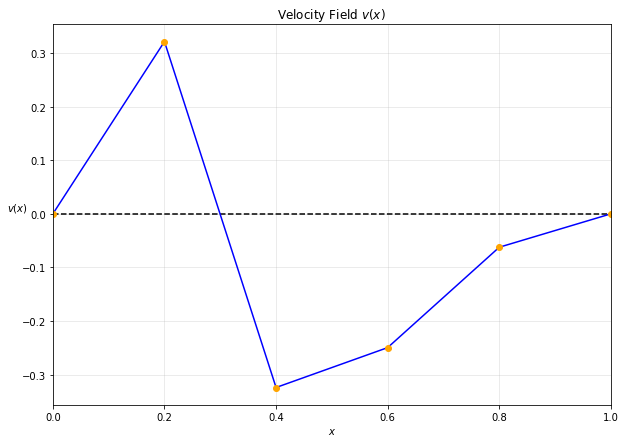

In [4]:
T.visualize_velocity(theta);

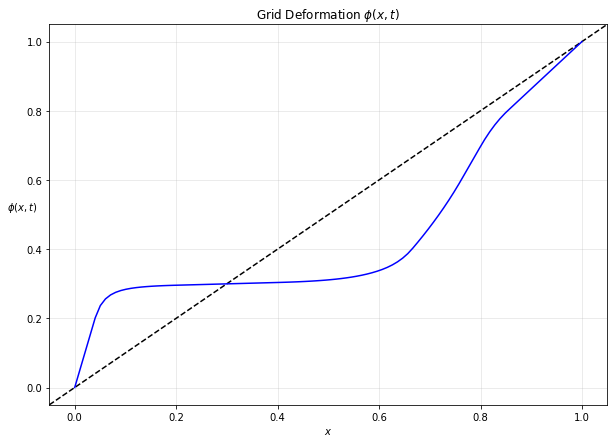

In [5]:
T.visualize_deformgrid(theta);

The dotted black line represents the identity tranformation $\phi(x,t) = x$.

## Integration details

By default, the velocity field is integrated up to $t==1$. The following figure shows the how the transformed grid changes along the integration time $t$.

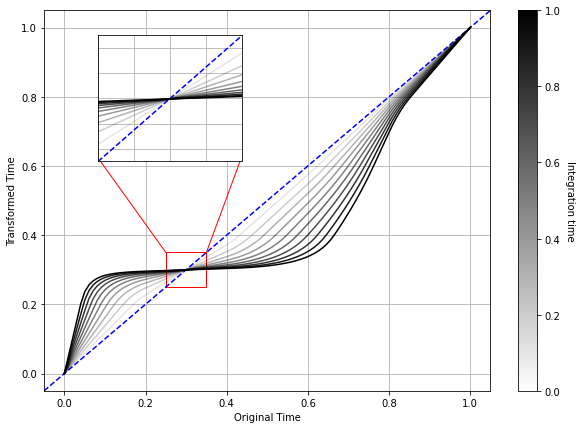

In [6]:
grid = T.uniform_meshgrid(outsize)
theta = T.identity(batch_size, epsilon=2)

fig, ax = plt.subplots()
ax_zoom = fig.add_axes([0.2,0.58,0.2,0.25])

ax.axline((0,0),(1,1), color="blue", ls="dashed")
ax_zoom.axline((0,0),(1,1), color="blue", ls="dashed")

N = 11
for i in range(N):
    time = i / (N-1)
    grid_t = T.transform_grid(grid, theta, time=time)
    ax.plot(grid, grid_t.T, label=round(time, 2), color="black", alpha=time)
    ax_zoom.plot(grid, grid_t.T, label=round(time, 2), color="black", alpha=time)

ax.grid()
ax.set_xlabel("Original Time")
ax.set_ylabel("Transformed Time")

sm = plt.cm.ScalarMappable(cmap="gray_r")
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Integration time', rotation=270)

ax_zoom.grid()
ax_zoom.set_xlim(.25, .35)
ax_zoom.set_ylim(.25, .35)
ax_zoom.set_xticklabels([])
ax_zoom.set_yticklabels([])
ax_zoom.xaxis.set_ticks_position('none')
ax_zoom.yaxis.set_ticks_position('none')

from matplotlib.patches import Rectangle
import matplotlib.lines as lines
r = Rectangle((.25,.25), 0.1, 0.1, edgecolor="red", facecolor="none", lw=1)
ax.add_patch(r)

line = lines.Line2D([0.085,0.25], [0.62, 0.35], color="red", lw=1)
ax.add_line(line)
line = lines.Line2D([0.435,0.35], [0.62, 0.35], color="red", lw=1)
ax.add_line(line);



## Scaling and squaring

The DIFW library allows to use the scaling and squaring method to approximate the velocity field integration. This method uses the following property of diffeomorphic transformations to accelerate the computation of the integral:

$$\phi(x,t+s) = \phi(x,t) \circ \phi(x,s)$$

Thus, computing the transformation $\phi$ at time $t+s$ is equivalent to composing the transformations at time $t$ and $s$. In the scaling and squaring method, we impose $t=s$, so that we need to compute only one transformation and self-compose it: 

$$\phi(x,2t) = \phi(x,t) \circ \phi(x,t)$$

Repeating this procedure multiple times (N), we can efficienty approximate the integration:

$$\phi(x,t^{2N}) = \phi(x,t) \; \underbrace{\circ \; \cdots \; \circ}_{N} \; \phi(x,t)$$

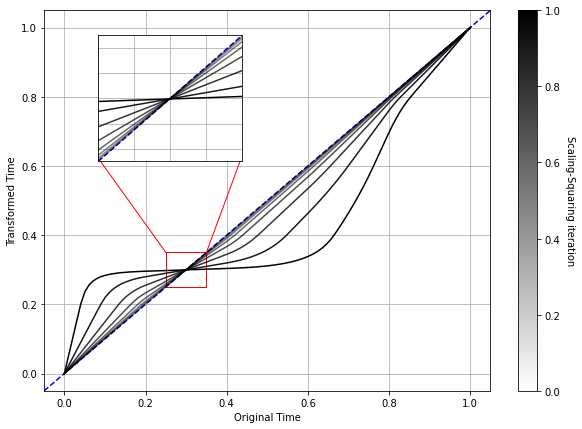

In [7]:
grid = T.uniform_meshgrid(outsize)
theta = T.identity(batch_size, epsilon=2)

fig, ax = plt.subplots()
ax_zoom = fig.add_axes([0.2,0.58,0.2,0.25])

ax.axline((0,0),(1,1), color="blue", ls="dashed")
ax_zoom.axline((0,0),(1,1), color="blue", ls="dashed")

N = 11
for i in range(N):
    alpha = i / (N-1)
    grid_t = T.transform_grid_ss(grid, theta / 2**N, N=i+1)
    ax.plot(grid, grid_t.T, label=round(time, 2), color="black", alpha=alpha)
    ax_zoom.plot(grid, grid_t.T, label=round(time, 2), color="black", alpha=alpha)

ax.grid()
ax.set_xlabel("Original Time")
ax.set_ylabel("Transformed Time")

sm = plt.cm.ScalarMappable(cmap="gray_r")
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Scaling-Squaring iteration', rotation=270)

ax_zoom.grid()
ax_zoom.set_xlim(.25, .35)
ax_zoom.set_ylim(.25, .35)
ax_zoom.set_xticklabels([])
ax_zoom.set_yticklabels([])
ax_zoom.xaxis.set_ticks_position('none')
ax_zoom.yaxis.set_ticks_position('none')

from matplotlib.patches import Rectangle
import matplotlib.lines as lines
r = Rectangle((.25,.25), 0.1, 0.1, edgecolor="red", facecolor="none", lw=1)
ax.add_patch(r)

line = lines.Line2D([0.085,0.25], [0.62, 0.35], color="red", lw=1)
ax.add_line(line)
line = lines.Line2D([0.435,0.35], [0.62, 0.35], color="red", lw=1)
ax.add_line(line);

## Data transformation

The time series data must have a shape (batch, length, channels). In this example, we have created a sinusoidal dataset of one batch, 50 points in length, and 2 channels. Then, to transform time series data, we can use the ``transform_data`` method and pass as arguments:

- data: n-dimensional array of shape (batch, length, channels)
- theta: transformation parameters
- outsize: length of the transformed data, with final shape (batch, outsize, channels)

In [8]:
batch_size = 1
length = 50
channels = 2
outsize = 100

# Generation
m = np.ones((batch_size, channels))
x = np.linspace(m*0, m*2*np.pi, length, axis=1)
data = np.sin(x)

theta = T.identity(batch_size, epsilon=1)
data_t = T.transform_data(data, theta, outsize)

And we can visualize this data transformation with the ``visualize_deformdata`` method. The <span style="color:red">red</span> curves represent the original data and the <span style="color:blue">blue</span> ones are the transformed data after applying the transformation.

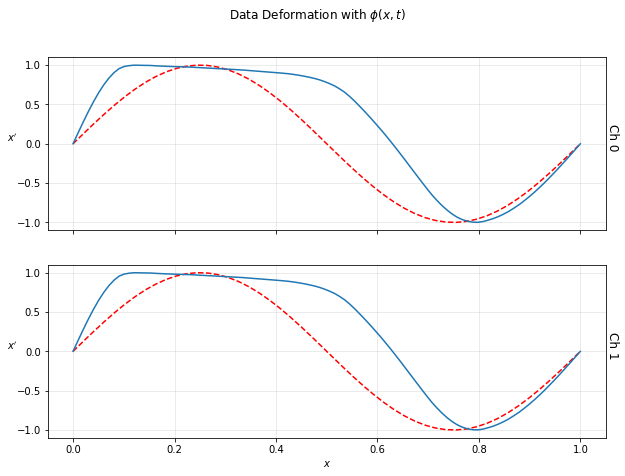

In [9]:
T.visualize_deformdata(data, theta);